# 触媒データ

Pymatgenを使った記述子算出と網羅的なモデル学習を行う

記述子として元々のデータに含まれていたセット`ORIGINAL`とそれらに元素ごとの物性値を存在比で重み付けしたセット`VARIABLE`を使う。<br>
予測モデルにはPLSとランダムフォレストを使用し、3変数をまとめて予測する多変量予測モデルを作る。

### Pymatgenを使った記述子計算

In [43]:
import pandas as pd
from pymatgen.core.periodic_table import Element, Specie
import numpy as np 

from sklearn.cross_decomposition import PLSRegression 
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

#警告を無視
from warnings import filterwarnings
filterwarnings('ignore')

#可視化
import matplotlib as mpl
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv('../data/catalyst/journal_data.csv',index_col=0)
df.head(10)

,Ag,K,Mo,W,Re,Au,Cl,Mg,Fe,Temp,...,O2,NOx,EtCl,CO2,pNOx,pEtCl,pCO2,Conv,Sel,Yield
label,,,,,,,,,,,,,,,,,,,,,
1,40,2.0,0.00,4.7,0.00,0.0,0.0,0.0,0.0,258,...,5.0,0.02,0.005,10.0,0,0,0,12.0,48.0,5.8
2,40,2.0,0.00,4.7,0.00,0.0,0.0,0.0,0.0,258,...,5.0,0.02,0.005,5.0,0,0,0,13.0,44.0,5.7
3,50,2.0,0.50,0.0,0.00,0.0,0.0,0.0,0.0,260,...,5.0,0.02,0.005,0.0,0,0,1,13.0,44.0,5.7
4,50,2.0,0.50,0.0,0.00,0.0,0.0,0.0,0.0,260,...,5.0,0.02,0.005,0.0,0,0,0,13.0,42.0,5.5
5,40,2.0,0.00,4.7,0.00,0.0,0.0,0.0,0.0,258,...,5.0,0.02,0.005,25.0,0,0,0,10.0,54.0,5.4
6,51,2.1,0.51,0.0,0.00,0.0,0.0,0.0,0.0,250,...,8.0,0.00,0.000,0.0,0,1,1,10.0,54.0,5.4
7,40,2.0,0.00,4.7,0.00,0.0,0.0,0.0,0.0,258,...,5.0,0.02,0.005,0.0,0,0,1,13.0,41.0,5.3
8,51,1.6,1.80,0.0,0.00,0.0,0.0,0.0,0.0,250,...,5.0,0.02,0.005,0.0,0,0,0,13.0,40.0,5.2
9,45,1.3,0.00,0.0,0.37,0.0,0.0,0.0,0.0,250,...,5.0,0.02,0.005,0.0,0,0,0,14.0,37.0,5.2


In [45]:
elem_names = [e for e in dir(Element) if not e.startswith('_')] 

In [46]:
len(elem_names)

118

In [86]:
element_name = 'Be'
elem = Element(element_name)

In [93]:
dictionary = []
elements = []

for name in elem_names:
    
    elem = Element(name)
    
    try:
        dictionary.append(elem.atomic_orbitals)
        elements.append(name)
    except:
        pass

In [94]:
len(dictionary)

103

In [95]:
df_orbits = pd.DataFrame([c if c is not None else {} for c in dictionary], index = elements).fillna(0.)
print(len(dictionary), df_orbits.shape)
df_orbits

103 (103, 18)


,1s,2p,2s,3d,3p,3s,4d,4f,4p,4s,5d,5p,5s,6d,6p,6s,7s,5f
Ac,-3443.110367,-572.762700,-592.622878,-119.541743,-137.654394,-147.320716,-23.570610,-12.278225,-31.761846,-36.158260,-3.222752,-6.065110,-7.713078,-0.137786,-0.744524,-1.196980,-0.126551,0.0
Ag,-900.324578,-120.913351,-129.859807,-13.367803,-20.067630,-23.678437,-0.298706,0.000000,-2.086602,-3.223090,0.000000,0.000000,-0.157407,0.000000,0.000000,0.000000,0.000000,0.0
Al,-55.156044,-2.564018,-3.934827,0.000000,-0.102545,-0.286883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Am,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Ar,-113.800134,-8.443439,-10.794172,0.000000,-0.382330,-0.883384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xe,-1208.688993,-172.599583,-183.327495,-24.378230,-32.867042,-37.415454,-2.286666,0.000000,-5.063802,-6.678340,0.000000,-0.309835,-0.672086,0.000000,0.000000,0.000000,0.000000,0.0
Y,-605.631981,-74.803201,-81.789102,-5.671499,-10.399926,-12.992217,-0.108691,0.000000,-1.024490,-1.697124,0.000000,0.000000,-0.150727,0.000000,0.000000,0.000000,0.000000,0.0
Yb,-2084.069389,-323.178219,-337.978976,-56.026315,-68.698655,-75.476630,-6.574963,-0.286408,-11.558246,-14.312076,0.000000,-0.966137,-1.683886,0.000000,0.000000,-0.136989,0.000000,0.0
Zn,-344.969756,-36.648765,-41.531323,-0.398944,-3.022363,-4.573041,0.000000,0.000000,0.000000,-0.222725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [143]:
tuple_vars = ['boiling_point', 'melting_point', 'liquid_range', 'mendeleev_no', 'molar_volume', 'thermal_conductivity']
tuple_vars

['boiling_point',
 'melting_point',
 'liquid_range',
 'mendeleev_no',
 'molar_volume',
 'thermal_conductivity']

In [144]:
elements_indesc = [c_ for c_ in df.columns if c_ in elements]
elements_indesc

['Ag', 'K', 'Mo', 'W', 'Re', 'Au', 'Cl', 'Mg', 'Fe', 'P']

In [126]:
df.columns

Index(['Ag', 'K', 'Mo', 'W', 'Re', 'Au', 'Cl', 'Mg', 'Fe', 'Temp', 'P', 'GHSV',
       'C3', 'O2', 'NOx', 'EtCl', 'CO2', 'pNOx', 'pEtCl', 'pCO2', 'Conv',
       'Sel', 'Yield'],
      dtype='object')

In [128]:
map_from_y_with_x = lambda x,y: list(map(x, y))

In [129]:
X = map_from_y_with_x(lambda elem: map_from_y_with_x(lambda method: getattr(Element(elem), method), list(tuple_vars)), elements_indesc)

In [130]:
X

[[2435.0, 1234.93, 1200.07, 71.0, 10.27, 430.0],
 [1032.0, 336.53, 695.47, 10.0, 45.94, 100.0],
 [4912.0, 2896.0, 2016.0, 56.0, 9.38, 139.0],
 [5828.0, 3695.0, 2133.0, 55.0, 9.47, 170.0],
 [5869.0, 3459.0, 2410.0, 58.0, 8.86, 48.0],
 [3129.0, 1337.33, 1791.67, 70.0, 10.21, 320.0],
 [239.11, 171.6, 67.51, 99.0, 17.39, 0.0089],
 [1363.0, 923.0, 440.0, 73.0, 14.0, 160.0],
 [3134.0, 1811.0, 1323.0, 61.0, 7.09, 80.0],
 [550.0, 317.3, 232.7, 90.0, 17.02, 0.236]]

In [131]:
# データフレーム dfの元素部分を取り出し
# 元素の並び順に元素特徴量をElementクラスから取り出してdf_Xへ保存

df_X = pd.DataFrame(X,columns=tuple_vars,index=elements_indesc)
df_X

,boiling_point,melting_point,liquid_range,mendeleev_no,molar_volume,thermal_conductivity
Ag,2435.00,1234.93,1200.07,71.0,10.27,430.0000
K,1032.00,336.53,695.47,10.0,45.94,100.0000
Mo,4912.00,2896.00,2016.00,56.0,9.38,139.0000
W,5828.00,3695.00,2133.00,55.0,9.47,170.0000
Re,5869.00,3459.00,2410.00,58.0,8.86,48.0000
Au,3129.00,1337.33,1791.67,70.0,10.21,320.0000
Cl,239.11,171.60,67.51,99.0,17.39,0.0089
Mg,1363.00,923.00,440.00,73.0,14.00,160.0000
Fe,3134.00,1811.00,1323.00,61.0,7.09,80.0000
P,550.00,317.30,232.70,90.0,17.02,0.2360


**元素の物性値を使った記述子の算出**

以下の要領で存在比$C$と元素の物性値$X_{\rm pure}$から <br>
記述子を計算する。

```python 
C @ Xpure
``` 

**ORIGINAL記述子セット**<br>
元々の触媒の記述子$X_{\rm mix}$を使う

**VARIABLE記述子セット**<br>
元々の触媒の記述子$X_{\rm mix}$に$CX_{\rm pure}$を追加した<br>
$[X_{\rm mix},~CX_{\rm pure}]$を利用する<br>
（行列を横に結合している）。


In [133]:
X_combi = pd.concat((df_X, df_orbits), axis=1) # Element全体

Xpure   = X_combi.loc[elements_indesc] # dfに含まれる元素だけをリストアップ


In [134]:
Xmix = df[Xpure.index] @ Xpure # 元素組成比 × 元素記述子
print(Xmix.shape)
Xmix.head(4)

(75, 24)


,boiling_point,melting_point,liquid_range,mendeleev_no,molar_volume,thermal_conductivity,1s,2p,2s,3d,...,4p,4s,5d,5p,5s,6d,6p,6s,7s,5f
label,,,,,,,,,,,,,,,,,,,,,
1,148855.6,80128.76,68726.84,6718.5,1227.989,18208.44,-50315.190483,-6774.532095,-7282.068060,-848.318619,...,-151.591059,-211.683976,-1.036834,-7.070948,-17.557565,0.0,0.0,-0.852641,0.0,0.0
2,148855.6,80128.76,68726.84,6718.5,1227.989,18208.44,-50315.190483,-6774.532095,-7282.068060,-848.318619,...,-151.591059,-211.683976,-1.036834,-7.070948,-17.557565,0.0,0.0,-0.852641,0.0,0.0
3,148270.0,76559.56,71710.44,7198.0,1290.870,21778.94,-48670.150753,-6294.695703,-6821.094011,-672.519011,...,-105.025125,-162.449542,0.000000,0.000000,-7.944290,0.0,0.0,0.000000,0.0,0.0
4,148270.0,76559.56,71710.44,7198.0,1290.870,21778.94,-48670.150753,-6294.695703,-6821.094011,-672.519011,...,-105.025125,-162.449542,0.000000,0.000000,-7.944290,0.0,0.0,0.000000,0.0,0.0


In [135]:
Xcalc = pd.concat((Xmix,df), axis=1)
print(Xcalc.shape)

(75, 47)


In [136]:
Xcalc.head(4)

,boiling_point,melting_point,liquid_range,mendeleev_no,molar_volume,thermal_conductivity,1s,2p,2s,3d,...,O2,NOx,EtCl,CO2,pNOx,pEtCl,pCO2,Conv,Sel,Yield
label,,,,,,,,,,,,,,,,,,,,,
1,148855.6,80128.76,68726.84,6718.5,1227.989,18208.44,-50315.190483,-6774.532095,-7282.068060,-848.318619,...,5.0,0.02,0.005,10.0,0,0,0,12.0,48.0,5.8
2,148855.6,80128.76,68726.84,6718.5,1227.989,18208.44,-50315.190483,-6774.532095,-7282.068060,-848.318619,...,5.0,0.02,0.005,5.0,0,0,0,13.0,44.0,5.7
3,148270.0,76559.56,71710.44,7198.0,1290.870,21778.94,-48670.150753,-6294.695703,-6821.094011,-672.519011,...,5.0,0.02,0.005,0.0,0,0,1,13.0,44.0,5.7
4,148270.0,76559.56,71710.44,7198.0,1290.870,21778.94,-48670.150753,-6294.695703,-6821.094011,-672.519011,...,5.0,0.02,0.005,0.0,0,0,0,13.0,42.0,5.5


In [137]:
TARGET = ['Conv', 'Sel', 'Yield']
VARIABLE = Xmix.columns.tolist() + df.columns[:-3].tolist() # 元素記述子を含めた記述子
ORIGINAL = df.columns[:-3].tolist() # 元々の記述子 

In [138]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [139]:
train_data, test_data = train_test_split(Xcalc, test_size=.33, random_state=66)
print(train_data.shape[0], test_data.shape[0])

50 25


In [140]:
n_folds = 5
models = {}

for model_name, base in zip(['pls', 'rf' ], [PLSRegression(), RandomForestRegressor()]):
    if model_name not in models.keys():
        models[model_name] = {}
    for desc_name, vars in zip(['variable', 'original'], [VARIABLE, ORIGINAL]):
        Xtrain = train_data[vars]
        ytrain = train_data[TARGET]
        Xtest = test_data[vars]
        ytest = test_data[TARGET]
        
        if model_name == 'pls':
            pipe = make_pipeline(StandardScaler(), base)
            params={'plsregression__n_components': np.arange(1,11)}
            model = GridSearchCV(pipe, params, cv=n_folds)
        elif model_name == 'rf': 
            pipe=base
            model = RandomizedSearchCV(pipe, random_grid, n_iter=100, 
                                       cv=n_folds, verbose=2, random_state=42, n_jobs = -1)
        model.fit(Xtrain, ytrain)
        print(model_name, desc_name,'CV_all: %.3f '%model.best_score_)
        for g_name, Xs, yo in zip(['train','test'], [Xtrain, Xtest], [ytrain, ytest]):
            yp = model.predict(Xs)
            print(g_name, end=' ')
            for i_comp in range(len(TARGET)):
                print(TARGET[i_comp]+' %.3f'%r2_score(yo.iloc[:,i_comp], yp[:,i_comp]), 
                      end=' ')
        models[model_name][desc_name] = model 
        print()

pls variable CV_all: 0.123 
train Conv 0.659 Sel 0.691 Yield 0.485 test Conv 0.594 Sel 0.632 Yield 0.345 
pls original CV_all: 0.142 
train Conv 0.387 Sel 0.290 Yield 0.247 test Conv 0.441 Sel 0.476 Yield 0.149 
Fitting 5 folds for each of 100 candidates, totalling 500 fits
rf variable CV_all: 0.527 
train Conv 0.950 Sel 0.964 Yield 0.927 test Conv 0.830 Sel 0.795 Yield 0.706 
Fitting 5 folds for each of 100 candidates, totalling 500 fits
rf original CV_all: 0.550 
train Conv 1.000 Sel 0.999 Yield 0.999 test Conv 0.789 Sel 0.742 Yield 0.621 


#### 寄与率を可視化

Random forestモデルの解釈を試みる。

In [141]:
mpl.rcParams['font.size'] = 16 
mpl.rcParams['font.family'] = 'MS Gothic'# Windows用日本語フォント
mpl.rcParams['figure.figsize'] = [12, 8]

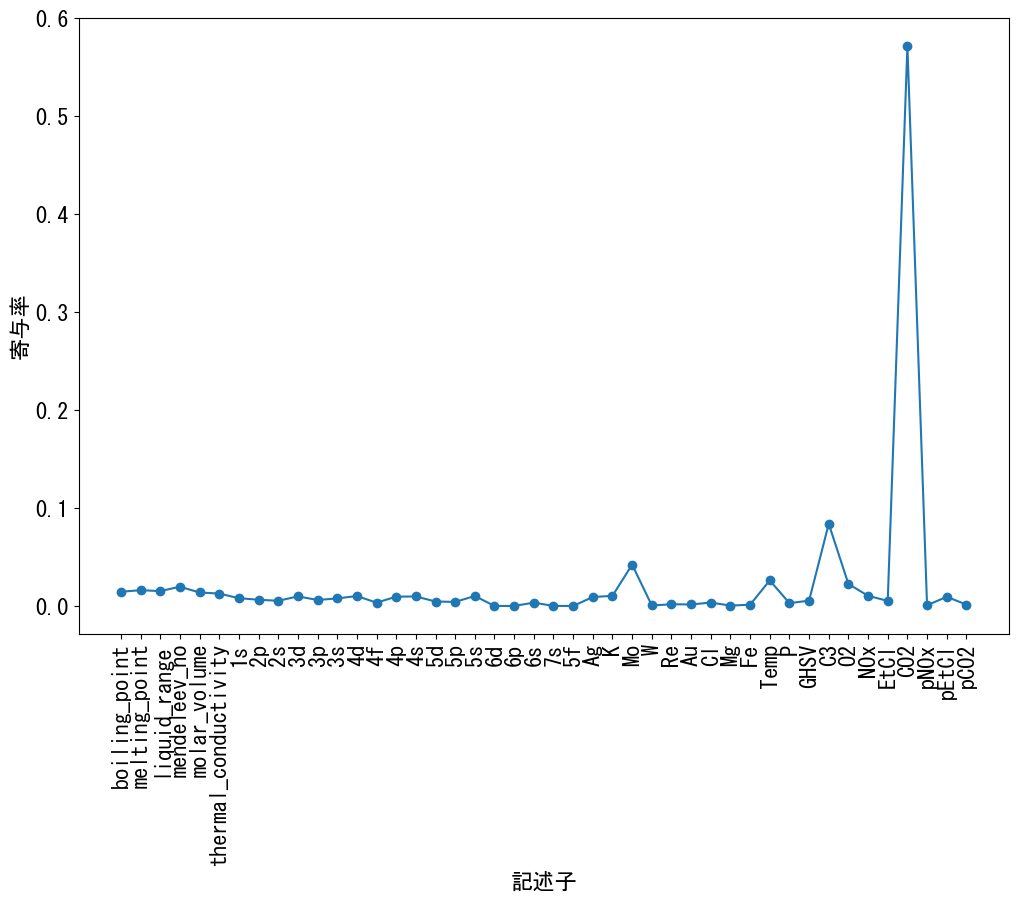

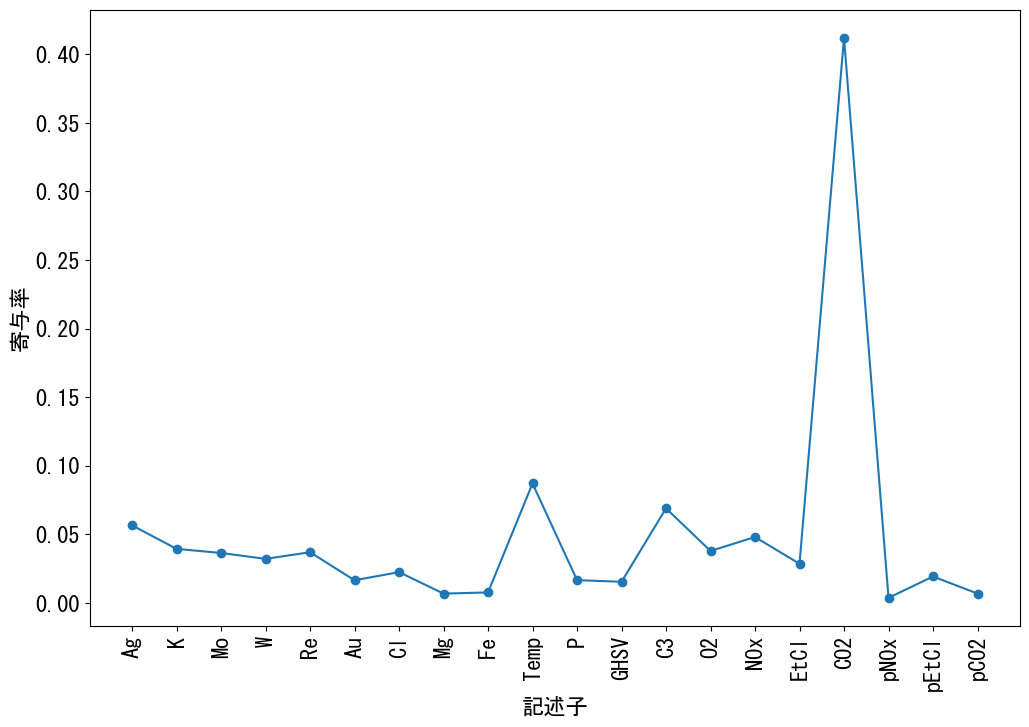

In [142]:
for desc_name, labels_xticks in zip(['variable', 'original'],[VARIABLE, ORIGINAL]): 
    fig, ax= plt.subplots()
    ax.plot(models['rf'][desc_name].best_estimator_.feature_importances_, '-o')
    plt.xticks(range(len(labels_xticks)))
    ax.set_xticklabels(labels_xticks, rotation=90)
    plt.xlabel('記述子')
    plt.ylabel('寄与率')
    plt.show()

## 考察の例

- `ORIGINAL`と`VARIABLE`の記述子セットを利用しても精度に差は見られなかった
- PLSとランダムフォレストではランダムフォレストの方が予測精度が高かった
  - すなわち、目的変数と説明変数の間には非線形性が成り立つ
- [元となる論文](https://www.jstage.jst.go.jp/article/jcac/7/0/7_0_69/_article/-char/ja/)
   ではPLSと変数選択を組み合わせたGAPLSを用いた解析を行っていたが、精度は低かった
- ランダムフォレストにおいて記述子寄与率を確認すると$CO_2$濃度が重要な変数であることが分かった